# Programming for Data Science - Final Project : Invoice Data Analysis

## The Team

This project was done by Andrea Zanin, Clément Vurpillot and Antoine Ursel from DIA 6.

---

## 1. Introduction

Many phenomena can be modeled using computational systems. The modeling process begins by identifying the objects that comprise the overall system. Next, the attributes or characteristics of objects that simplify reality are described. These objects and their attributes are stored in data repositories such as databases, data warehouses, data lakes, and spreadsheets. Later, instances of these objects are created, populating the database. Data is essential for extracting information that improves our understanding of the phenomena under study and informs data-driven decision-making.

In this context, in this final project, the techniques learned in this course will be used to extract and visualize helpful information from different data sources.

---

## 2. Project Structure

1. **Data Exploration**: Explore the data using data summarization methods to fully understand it
2. **Indicator Extraction**: Extract four key indicators from the dataset using various techniques
3. **Visualization Dashboard**: Create a visualization of the four key indicators built in 2.

---

## 3. About the Dataset

The invoice dataset is a synthetic dataset created with the Python Faker library, designed to replicate the structure of data typically gathered from an online store. It includes multiple fields such as:

- **Customer details**: first name, last name, email
- **Transaction information**: product ID, quantity, amount, invoice date
- **Additional attributes**: address, city, stock code, job title



---

# Step 1: Data Collection

## 1.1 Import Required Libraries

We'll use pandas for data manipulation, matplotlib and seaborn for visualization, and numpy for numerical operations. These libraries provide the necessary tools for loading, exploring, and visualizing the dataset.


In [782]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX
import plotly.graph_objects as go
from typing import Tuple
import warnings
from mlxtend.frequent_patterns import apriori, association_rules




warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1.2 Data Loading and Storage

### Function: load_invoice_data()

This function loads the CSV file and stores it in a pandas DataFrame, which provides excellent data manipulation capabilities. The DataFrame structure allows us to perform various operations such as filtering, grouping, aggregating, and transforming the data efficiently.


In [783]:
def load_invoice_data(file_path):
    """
    Load invoice data from CSV file into a pandas DataFrame.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing invoice data
    
    Returns:
    --------
    pd.DataFrame
        DataFrame containing the invoice data
    """
    # Read CSV file into pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Convert invoice_date to datetime format for better manipulation
    df['invoice_date'] = pd.to_datetime(df['invoice_date'], format='%d/%m/%Y', errors='coerce')
    
    return df


## 1.3 Data Exploration

Data exploration is a crucial step in understanding our dataset. We need to examine the structure, content, and quality of the data before proceeding with analysis.

### Function: explore_dataset()

This function performs comprehensive data exploration including:
- **Number of rows and columns**: Understanding the dataset dimensions
- **Column names and data types**: Identifying all attributes and their types
- **Missing data analysis**: Detecting any missing values in each column
- **Basic statistical summaries**: Computing descriptive statistics for numerical and categorical variables
- **Variable correlations**: Calculating relationships between numerical variables (ranking between variables)


In [784]:
def explore_dataset(df):
    """
    Explore and summarize the dataset to understand its structure and content.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    dict
        Dictionary containing exploration results
    """
    exploration_results = {}
    
    # Basic dataset dimensions
    exploration_results['num_rows'] = len(df)
    exploration_results['num_columns'] = len(df.columns)
    exploration_results['column_names'] = df.columns.tolist()
    
    # Data types for each column
    exploration_results['data_types'] = df.dtypes.to_dict()
    
    # Missing data analysis
    missing_data = df.isnull().sum()
    missing_percentage = (missing_data / len(df)) * 100
    exploration_results['missing_data'] = pd.DataFrame({
        'Missing Count': missing_data,
        'Percentage': missing_percentage
    })
    
    # Basic statistics for numerical columns
    exploration_results['numerical_stats'] = df.describe()
    
    # Basic statistics for categorical columns
    exploration_results['categorical_stats'] = df.describe(include=['object'])
    
    # Calculate correlations between numerical variables
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    if len(numerical_cols) > 1:
        exploration_results['correlations'] = df[numerical_cols].corr()
    else:
        exploration_results['correlations'] = pd.DataFrame()
    
    return exploration_results


In [785]:
def display_exploration_results(exploration_results, df):
    """
    Display the exploration results in a formatted manner.
    
    Parameters:
    -----------
    exploration_results : dict
        Dictionary containing exploration results from explore_dataset()
    df : pd.DataFrame
        Original DataFrame for additional analysis
    """
    print("=" * 80)
    print("DATASET EXPLORATION SUMMARY")
    print("=" * 80)
    
    print(f"\n1. Dataset Dimensions:")
    print(f"   - Number of rows: {exploration_results['num_rows']:,}")
    print(f"   - Number of columns: {exploration_results['num_columns']}")
    
    print(f"\n2. Column Names:")
    for i, col in enumerate(exploration_results['column_names'], 1):
        print(f"   {i}. {col}")
    
    print(f"\n3. Data Types:")
    for col, dtype in exploration_results['data_types'].items():
        print(f"   - {col}: {dtype}")
    
    print(f"\n4. Missing Data Analysis:")
    missing_df = exploration_results['missing_data']
    missing_df = missing_df[missing_df['Missing Count'] > 0]
    if len(missing_df) > 0:
        print(missing_df.to_string())
    else:
        print("   No missing data found in the dataset!")
    
    print(f"\n5. Numerical Columns Summary:")
    print(exploration_results['numerical_stats'].to_string())
    
    print(f"\n6. Categorical Columns Summary:")
    print(exploration_results['categorical_stats'].to_string())
    
    print(f"\n7. Variable Correlations (Numerical Variables):")
    if len(exploration_results['correlations']) > 0:
        corr_df = exploration_results['correlations']
        print("\n   Correlation Matrix:")
        print(corr_df.to_string())
        
        # Display strongest correlations (excluding self-correlations of 1.0)
        print("\n   Strongest Correlations (excluding self-correlations):")
        corr_pairs = []
        for i in range(len(corr_df.columns)):
            for j in range(i+1, len(corr_df.columns)):
                col1 = corr_df.columns[i]
                col2 = corr_df.columns[j]
                corr_value = corr_df.iloc[i, j]
                if not pd.isna(corr_value):
                    corr_pairs.append((col1, col2, corr_value))
        
        # Sort by absolute correlation value
        corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
        
        # Display top correlations
        for col1, col2, corr_val in corr_pairs[:10]:  # Show top 10
            strength = "strong" if abs(corr_val) > 0.7 else "moderate" if abs(corr_val) > 0.4 else "weak"
            direction = "positive" if corr_val > 0 else "negative"
            print(f"   {col1} / {col2}: {corr_val:.4f} ({strength} {direction})")
    else:
        print("   No numerical variables found for correlation analysis.")
    
    print("\n" + "=" * 80)


## 1.4 Data Visualization for Understanding

Visual components are essential for understanding data distributions, patterns, and relationships. These visualizations help us identify outliers, understand variable distributions, and detect potential issues in the data.

We have split the data overview visualizations into three separate functions, each focusing on a specific aspect of the data:

### Function 1: visualize_invoice_amounts_distribution()

This function creates a histogram showing the frequency distribution of invoice amounts. This visualization helps us understand:
- The range of invoice values in the dataset
- The most common invoice amounts
- Whether the distribution is normal, skewed, or has multiple peaks
- Potential outliers or unusual patterns in the data

 


In [786]:
def visualize_invoice_amounts_distribution(df):
    """
    Visualize the distribution of invoice amounts using a histogram.
    
    This function creates a histogram that shows how invoice amounts are distributed
    across the dataset. It helps identify the most common invoice values, detect
    outliers, and understand the overall spending patterns.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df['amount'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Invoice Amounts', fontsize=14, fontweight='bold')
    plt.xlabel('Amount ($)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### Function 2 : visualize_top_customers()

This function creates a horizontal bar chart showing the top customers ranked by their total lifetime value. This visualization helps us understand:
- Which customers generate the most revenue over time
- Customer loyalty and repeat purchase patterns
- The distribution of customer lifetime values
- Identification of VIP customers who may require special attention or loyalty programs
- Average invoice values for top customers


In [787]:
def visualize_top_customers(df, top_n=20):
    """
    Visualize top customers by total lifetime value, showing their spending patterns.
    Identifies repeat customers and ranks them by total spending.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    top_n : int, default=20
        Number of top customers to display
    """
    # Group by email to identify customers
    customer_analysis = df.groupby('email').agg({
        'amount': ['sum', 'mean', 'count'],
        'first_name': 'first',
        'last_name': 'first',
        'city': 'first'
    }).reset_index()
    
    # Flatten column names
    customer_analysis.columns = ['email', 'total_spending', 'avg_invoice_value', 
                                 'invoice_count', 'first_name', 'last_name', 'city']
    
    # Create customer name
    customer_analysis['customer_name'] = customer_analysis['first_name'] + ' ' + customer_analysis['last_name']
    
    # Sort by total spending
    customer_analysis = customer_analysis.sort_values('total_spending', ascending=False).head(top_n)
    
    # Create horizontal bar chart
    plt.figure(figsize=(14, 10))
    y_pos = np.arange(len(customer_analysis))
    
    bars = plt.barh(y_pos, customer_analysis['total_spending'].values, 
                     color='#8B4C89', alpha=0.8)
    
    # Add value labels
    for i, (idx, row) in enumerate(customer_analysis.iterrows()):
        plt.text(row['total_spending'] + max(customer_analysis['total_spending']) * 0.01,
                i, f"${row['total_spending']:,.0f} ({row['invoice_count']} invoices)",
                va='center', fontsize=9, fontweight='bold')
    
    # Truncate long names
    customer_labels = [name[:25] + '...' if len(name) > 25 else name 
                       for name in customer_analysis['customer_name'].values]
    
    plt.yticks(y_pos, customer_labels)
    plt.xlabel('Total Lifetime Value ($)', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Customers by Lifetime Value', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print(f"TOP {top_n} CUSTOMERS ANALYSIS")
    print("=" * 80)
    for idx, row in customer_analysis.head(10).iterrows():
        print(f"\n{row['customer_name']} ({row['city']}):")
        print(f"  Total Lifetime Value: ${row['total_spending']:,.2f}")
        print(f"  Average Invoice Value: ${row['avg_invoice_value']:,.2f}")
        print(f"  Number of Purchases: {row['invoice_count']}")
    print("=" * 80 + "\n")


### Function 3: visualize_top_cities_by_invoice_count()

This function creates a horizontal bar chart showing the top 10 cities ranked by the number of invoices. This visualization helps us understand:
- Which cities generate the most business activity
- Geographic distribution of transactions
- Market concentration across different locations
- Potential areas for business expansion or marketing focus


In [788]:
def visualize_top_cities_by_invoice_count(df, top_n=10):
    """
    Visualize the top cities by invoice count using a horizontal bar chart.
    
    This function identifies and displays the cities with the highest number
    of invoices, providing insights into geographic business distribution and
    identifying key markets.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    top_n : int, default=10
        Number of top cities to display
    """
    plt.figure(figsize=(10, 6))
    top_cities = df['city'].value_counts().head(top_n)
    plt.barh(range(len(top_cities)), top_cities.values, color='green', alpha=0.7)
    plt.yticks(range(len(top_cities)), top_cities.index)
    plt.title(f'Top {top_n} Cities by Invoice Count', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Invoices')
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()


### Function 4: visualize_yearly_revenue_trends()

This function creates a line plot showing total invoice amounts aggregated by year. This visualization helps us understand:
- Revenue trends over time
- Growth or decline patterns in business performance
- Seasonal or annual patterns in revenue
- Long-term business trajectory and forecasting opportunities


In [789]:
def visualize_yearly_revenue_trends(df):
    """
    Visualize yearly revenue trends using a line plot.
    
    This function aggregates invoice amounts by year and displays them as a
    time series line plot. It helps identify revenue trends, growth patterns,
    and temporal changes in business performance.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Note:
    -----
    This function requires valid date information in the 'invoice_date' column.
    If dates are not available, the function will not display a visualization.
    """
    if 'invoice_date' not in df.columns or df['invoice_date'].notna().sum() == 0:
        print("Date information not available for yearly revenue trend analysis.")
        return
    
    plt.figure(figsize=(12, 6))
    df_time = df.dropna(subset=['invoice_date']).copy()
    df_time['year'] = df_time['invoice_date'].dt.year
    yearly_amounts = df_time.groupby('year')['amount'].sum()
    
    plt.plot(yearly_amounts.index, yearly_amounts.values, marker='o', linewidth=2, markersize=8)
    plt.title('Total Invoice Amounts by Year', fontsize=14, fontweight='bold')
    plt.xlabel('Year')
    plt.ylabel('Total Amount ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


---

# Step 2: Information Extraction 

In this step, we apply different techniques to extract meaningful information from the dataset. This step includes:

1. **Grouping Queries** : Using SQL-like grouping operations to aggregate data
2. **Data Transformation Methods** : Discretization, and frequent pattern mining
3. **Temporal Analysis with Forecasting** : Time series analysis and revenue forecasting
4. **Visualization of extracted information** : Time series analysis and revenue forecasting

## 2.1 Grouping Queries

Grouping queries organize data into subsets based on shared characteristics. They help summarize large datasets and extract meaningful insights by aggregating values across categories.

### Function 1: get_job_with_most_invoices()

This function identifies **the job category that has generated the most invoices.**

**How it's calculated**: `df.groupby('job').size().idxmax()`, it groups invoices by job, counts invoices per group, and returns the job with the highest count.

**What it represents**: Highlights the profession whose customers create the largest volume of invoices.

**How to interpret**: Jobs with higher counts indicate the most active customer segments. Useful for targeting or understanding revenue sources by profession.

In [790]:
def get_job_with_most_invoices(df):
    """
    Find the job category that has the highest number of invoices.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the invoice data with a 'job' column

    Returns
    -------
    tuple
        (job_name, invoice_count) for the job with the most invoices
    """
    counts = df.groupby('job').size()
    job_name = counts.idxmax()
    max_count = counts.max()
    return job_name, max_count


### Function 2: get_top_selling_product()

This function finds **the product with the highest total quantity sold.**

**How it's calculated**: `df.groupby('product_id')['qty'].sum().idxmax()`, sums quantities sold per product and returns the product ID with the largest total.

**What it represents**: The best-selling product in terms of quantity across all invoices.

**How to interpret**: Products with higher total quantities indicate strong demand. Can inform inventory planning and marketing focus.

In [791]:
def get_top_selling_product(df):
    """
    Identify the product with the highest total quantity sold.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the invoice data with 'product_id' and 'qty'

    Returns
    -------
    tuple
        (product_id, total_quantity_sold)
    """
    qty_sum = df.groupby('product_id')['qty'].sum()
    product_id = qty_sum.idxmax()
    total_qty = qty_sum.max()
    return product_id, total_qty


### Function 3: get_city_with_highest_avg_invoice()

This function determines **the city with the highest average invoice amount.**

**How it's calculated**: `df.groupby('city')['amount'].mean().idxmax()`, computes the average invoice per city and returns the city with the highest value.

**What it represents**: Shows which city generates the highest revenue per transaction on average.

**How to interpret**: Cities with higher average invoice amounts reflect higher spending per customer. Useful for identifying premium markets.

In [792]:
def get_city_with_highest_avg_invoice(df):
    """
    Determine which city has the highest average invoice amount.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the invoice data with 'city' and 'amount'

    Returns
    -------
    tuple
        (city_name, average_invoice_amount)
    """
    avg_amount = df.groupby('city')['amount'].mean()
    city_name = avg_amount.idxmax()
    highest_avg = avg_amount.max()
    return city_name, highest_avg


### Function 4: get_city_with_most_unique_customers()

This function finds **the city with the largest number of unique customers based on distinct emails.**

**How it's calculated**: `df.groupby('city')['email'].nunique().idxmax()`, counts unique emails per city and returns the city with the highest number.

**What it represents**: Indicates the city with the broadest customer base.

**How to interpret**: Cities with more unique customers may require more resources to serve and present larger market potential.

In [793]:
def get_city_with_most_unique_customers(df):
    """
    Find the city that has the highest number of unique customers 
    based on distinct emails.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the invoice data with 'city' and 'email'

    Returns
    -------
    tuple
        (city_name, unique_customer_count)
    """
    unique_counts = df.groupby('city')['email'].nunique()
    city_name = unique_counts.idxmax()
    max_unique = unique_counts.max()
    return city_name, max_unique


## 2.2 Data Transformation Methods

Data transformation methods convert raw data into formats that are more suitable for analysis. We will apply three key transformation techniques:

1. **Discretization**: Converting continuous variables into categorical bins for pattern analysis
2. **Frequent Pattern Mining**: Discovering frequently occurring patterns or associations in the data


### Technique 1: Discretization

Discretization converts continuous numerical values into discrete categories or bins. This transformation helps identify patterns and simplifies analysis by grouping similar values together.

**Method**: Equal-width binning - divides the range into equal-sized intervals

**What it represents**: Categorical representation of continuous data

**How to interpret**: Each bin represents a range of values. This helps identify spending patterns, customer segments, and distribution characteristics.


In [794]:
def discretize_dataset(df):
    """
    Discretizes key numerical and categorical attributes.
    Creates quantity bins, price bins, and job spending segments.
    """

    df = df.copy()

    # Quantity bins (1–9 → Low / Medium / High)
    df['qty_bin'] = pd.cut(
    df['qty'],
    bins=[0, 2, 4, 6, 8, 10],
    labels=['1–2', '3–4', '5–6', '7–8', '9+']
)


    # Price bins (5–100 → Cheap / Mid-range / Premium)
    df['amount_bin'] = pd.qcut(
    df['amount'],
    q=5,
    labels=['Very Cheap', 'Cheap', 'Mid', 'Expensive', 'Very Expensive']
)

    return df






In [795]:
def discretize_invoice_amounts(df, n_bins=5):
    """
    Discretize invoice amounts into bins using equal-width discretization.
    
    This function converts continuous invoice amounts into discrete categories,
    which helps identify spending patterns and customer segments.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    n_bins : int, default=5
        Number of bins to create
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with original amounts and discretized categories
    """
    # Create a copy to avoid modifying original
    df_discretized = df.copy()
    
    # Define bin labels
    bin_labels = [f'Low (${df["amount"].min():.2f}-${df["amount"].quantile(0.2):.2f})',
                  f'Medium-Low (${df["amount"].quantile(0.2):.2f}-${df["amount"].quantile(0.4):.2f})',
                  f'Medium (${df["amount"].quantile(0.4):.2f}-${df["amount"].quantile(0.6):.2f})',
                  f'Medium-High (${df["amount"].quantile(0.6):.2f}-${df["amount"].quantile(0.8):.2f})',
                  f'High (${df["amount"].quantile(0.8):.2f}-${df["amount"].max():.2f})']
    
    # Discretize using quantile-based binning
    df_discretized['amount_category'] = pd.qcut(df['amount'], 
                                                  q=n_bins, 
                                                  labels=bin_labels[:n_bins],
                                                  duplicates='drop')
    
    return df_discretized[['amount', 'amount_category']]


### Technique 2: Frequent Pattern Mining

Frequent pattern mining identifies patterns that occur frequently in the dataset. We'll use association rule mining to find frequently co-occurring product combinations.

**Method**: Prepares a basket where each row corresponds to a job and each column is a product. It converts quantities into boolean to indicate purchase/no purchase. It uses the apriori algorithm to find the frequent bundles and generates association rules. 

**What it represents**: The products that are frequently bought together. For example if A is purchased then B is 80% sure to be bought too. 

**How to interpret**: High support values indicate common patterns. This helps in product bundling, recommendations, and understanding customer purchase behavior.

In [796]:
def market_basket_analysis(df, min_support=0.01, min_lift=1.5):
    """
    Perform Market Basket Analysis to identify products frequently purchased together.

    Parameters:
    -----------
    df : pd.DataFrame
    DataFrame containing invoice data with columns 'job', 'product_id', and 'qty'.
    min_support : float, optional
    Minimum support threshold for frequent itemsets (here its 0.01).
    min_lift : float, optional
    Minimum lift threshold for association rules (here its 1.5).

    Returns:
    --------
    pd.DataFrame
    Top 10 association rules sorted by lift, including antecedents, consequents,
    support, confidence, and lift.
    """
    # Create basket: rows = jobs, columns = products
    basket_job = df.groupby(['job', 'product_id'])['qty'].sum().unstack().fillna(0)
    basket_job = basket_job.astype(bool)

    # Generate frequent itemsets
    frequent_itemsets = apriori(basket_job, min_support=min_support, use_colnames=True)

    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_lift)

    # Return top 10 rules by lift
    return rules.sort_values(by='lift', ascending=False)[
        ['antecedents','consequents','support','confidence','lift']
    ].head(10)


## 2.3 Temporal Analysis with Forecasting

Temporal analysis examines how data changes over time. We'll analyze revenue trends and apply forecasting techniques to predict future values.

### Function: run_sarima_forecast_simple()

This function performs time series forecasting on your monthly revenue data using the SARIMA model.

**How it's calculated**: It takes the aggregated monthly revenue, applies a log transformation, fits the data to a SARIMA model, and generates a forecast for future months.

**What it represents**: A projection of future monthly revenue, including the most probable path (Forecast Mean) and the range of uncertainty (95% Confidence Interval).

**How to interpret**: The Forecast Mean shows the predicted long-term average revenue.
The Confidence Interval indicates the degree of month-to-month volatility captured by the model.

In [797]:
def run_sarima_forecast_simple(
    monthly_revenue: pd.Series, 
    forecast_steps: int,
    order: Tuple[int, int, int] = (1, 1, 1),
    seasonal_order: Tuple[int, int, int, int] = (1, 1, 1, 12)
) -> Tuple[pd.Series, pd.DataFrame, pd.Series]:
    """
    Runs the SARIMA model and returns forecast and historical log data.

    Parameters:
    -----------
    monthly_revenue : pd.Series
        The aggregated monthly revenue data (must have a DatetimeIndex).
    forecast_steps : int
        The number of future periods (months) to forecast.
    order : Tuple[int, int, int], optional
        The non-seasonal SARIMA parameters (p, d, q). Defaults to (1, 1, 1).
    seasonal_order : Tuple[int, int, int, int], optional
        The seasonal SARIMA parameters (P, D, Q, s). Defaults to (1, 1, 1, 12).
        """
    
    monthly_revenue_log = np.log(monthly_revenue[monthly_revenue > 0])

    model = SARIMAX(
        monthly_revenue_log, 
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_results = model.fit(disp=False) 

    forecast = sarima_results.get_forecast(steps=forecast_steps)

    forecast_mean = np.exp(forecast.predicted_mean)
    forecast_ci = np.exp(forecast.conf_int())

    return forecast_mean, forecast_ci, monthly_revenue_log

### Function: analyze_monthly_volatility()

This function measures the temporal trend of monthly revenue volatility, giving insight into the stability of your revenue over time.

**How it's calculated**: It aggregates daily revenue within each month and computes the standard deviation, producing a time series of monthly volatility.

**What it represents**: The standard deviation of daily revenue per month, which reflects how stable or erratic revenue is from day to day within each month.

**How to interpret**: Higher values indicate months with larger fluctuations in daily revenue (more volatility), while lower values indicate more consistent daily revenue (less volatility).

In [ ]:
def analyze_monthly_volatility(df: pd.DataFrame):
    """
    Analyzes the temporal trend of monthly revenue volatility (risk).
    It calculates the standard deviation of daily revenue within each month 
    to create a time series representing market stability.
    
    Parameters:
        df: The input DataFrame containing 'amount' and 'invoice_date'.
    """
    
    # Ensure date column is datetime
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    
    # --- 1. Aggregation: Calculate Daily Revenue ---
    daily_revenue = df.groupby(df['invoice_date'].dt.date)['amount'].sum()
    daily_revenue.index = pd.to_datetime(daily_revenue.index) # Convert index back to datetime object

    # --- 2. Temporal Feature: Monthly Volatility ---
    # Group the daily revenue by month and calculate the Standard Deviation (Volatility)
    monthly_volatility = daily_revenue.groupby(daily_revenue.index.to_period('M')).std()
    monthly_volatility.index = monthly_volatility.index.to_timestamp() # Convert index for plotting
    
    # Fill NaN values (months with only one transaction) with 0, as volatility cannot be calculated
    monthly_volatility = monthly_volatility.fillna(0) 

    



## 2.4 Visualization of Extracted Information

Each technique above produces results that need to be visualized for better understanding and interpretation. Below are visualizations for each method.


### Visualization: Grouping Queries Results


In [800]:
def visualize_grouping_queries_results(df):
    """
    Visualize results from grouping queries.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """

    # Get job category with most invoices
    job_with_most_invoices = get_job_with_most_invoices(df)
    
    # Get the product with the highest quantity sold
    product_with_highest_quantity = get_top_selling_product(df)

    # Get the city with the highest average invoice amount
    city_with_highest_avg_invoice = get_city_with_highest_avg_invoice(df)

    # Get the city with the most unique customers
    city_with_most_unique_customers = get_city_with_most_unique_customers(df)
    
    print("\n" + "=" * 80)
    print("GROUPING QUERIES RESULTS")
    print("=" * 80)
    print(f"\nJob Category with Most Invoices:")
    print(f"  Job Category: {job_with_most_invoices}")
    print(f"\nProduct with the Highest Quantity Sold:")
    print(f"  Product ID: {product_with_highest_quantity}")
    print(f"\nCity with the Highest Average Invoice Amount:")
    print(f"  City: {city_with_highest_avg_invoice}")
    print(f"\nCity with the Most Unique Customers:")
    print(f"  City: {city_with_most_unique_customers}")
    


### Visualization: Data Transformation Results


In [801]:
def visualize_data_transformation_results(df):
    """
    Visualize results from data transformation methods.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    """
    # Apply transformations
    normalized_data = normalize_invoice_amounts(df)
    discretized_data = discretize_invoice_amounts(df, n_bins=5)
    frequent_patterns = market_basket_analysis(df)
    
    # Create discretized columns for visualization
    df_viz = df.copy()
    df_viz['qty_bin'] = pd.cut(
        df_viz['qty'],
        bins=[0, 2, 4, 6, 8, 10],
        labels=['1–2', '3–4', '5–6', '7–8', '9+']
    )
    df_viz['amount_bin'] = pd.qcut(
        df_viz['amount'],
        q=5,
        labels=['Very Cheap', 'Cheap', 'Mid', 'Expensive', 'Very Expensive']
    )
    
    print("\n" + "=" * 80)
    print("DATA TRANSFORMATION RESULTS")
    print("=" * 80)

    # Visualization 1: Discretization results
    
    counts = df_viz['qty_bin'].value_counts().sort_index()
    plt.figure(figsize=(9,5))
    plt.bar(counts.index.astype(str), counts.values, color='steelblue')
    plt.title('Distribution of Quantity Bins')
    plt.xlabel('Quantity Bin')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    counts = df_viz['amount_bin'].value_counts().sort_index()
    plt.figure(figsize=(9,5))
    plt.bar(counts.index.astype(str), counts.values, color='darkgreen')
    plt.title('Distribution of Price Segments')
    plt.xlabel('Price Segment')
    plt.ylabel('Count')
    plt.grid(axis='y', alpha=0.3)
    plt.show()


    
    # Visualization 2: Frequent patterns
    if len(frequent_patterns) > 0:
        plt.figure(figsize=(12, 8))
        # Sort by confidence (highest to lowest) and take top 10
        top_rules = frequent_patterns.sort_values('confidence', ascending=False).head(10)
    
        # Create readable labels from antecedents and consequents
        labels = [
            f"{set(a)} → {set(c)}" 
            for a, c in zip(top_rules['antecedents'], top_rules['consequents'])
        ]
    
        # Plot horizontal bars
        plt.barh(range(len(top_rules)), top_rules['confidence'].values * 100, color='purple', alpha=0.8)
        plt.yticks(range(len(top_rules)), labels)
        plt.xlabel('Confidence (%)', fontsize=12, fontweight='bold')
        plt.title('Top 10 Market Basket Association Rules', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3, axis='x')
    
        # Add value labels
        for i, (_, row) in enumerate(top_rules.iterrows()):
            plt.text(row['confidence'] * 100 + max(top_rules['confidence']) * 100 * 0.01, i, f'{row["confidence"]*100:.2f}%',
                va='center', fontsize=9)
    
        plt.tight_layout()
        plt.show()
    
    # Print summary
    print("\n" + "=" * 80)
    print("DATA TRANSFORMATION RESULTS SUMMARY")
    print("=" * 80)    
    print(f"\nDiscretization Statistics:")
    category_counts = discretized_data['amount_category'].value_counts().sort_index()
    for category, count in category_counts.items():
        print(f"  {category}: {count:,} invoices ({count/len(discretized_data)*100:.1f}%)")
    
    if len(frequent_patterns) > 0:
        print(f"\nFrequent Patterns Found: {len(frequent_patterns)}")
        print(f"Top 3 Association Rules:")
        for idx, row in frequent_patterns.head(3).iterrows():
            antecedents_str = ', '.join([str(x) for x in row['antecedents']])
            consequents_str = ', '.join([str(x) for x in row['consequents']])
            print(f"  {antecedents_str} → {consequents_str}: "
                  f"Support = {row['support']*100:.2f}%, Confidence = {row['confidence']*100:.2f}%, Lift = {row['lift']:.2f}")
    else:
        print("\nNo frequent patterns found above the minimum support threshold.")
    print("=" * 80 + "\n")


### Visualization: Temporal Analysis and Forecasting Results


In [802]:
def visualize_temporal_analysis_and_forecasting(df: pd.DataFrame, forecast_steps: int = 24):
    """
    Performs monthly revenue aggregation, SARIMA forecasting, and visualization 
    using the raw DataFrame.

    Parameters:
    -----------
        df: The input DataFrame containing 'invoice_date' and 'amount'.
        forecast_steps: The number of months to forecast.
    """
    
    # 1. Temporal Data Aggregation 
    
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    
    # Aggregate monthly revenue
    df['month'] = df['invoice_date'].dt.to_period('M')
    monthly_revenue = df.groupby('month')['amount'].sum()
    monthly_revenue.index = monthly_revenue.index.to_timestamp() # Convert index for modeling

    
    # 2. Call the Forecasting Function
    # NOTE: You can pass custom order/seasonal_order here if you optimize them.
    forecast_mean, forecast_ci, monthly_revenue_log = run_sarima_forecast_simple(
        monthly_revenue, 
        forecast_steps=forecast_steps
    )
    
    # 3. Visualization
    plt.figure(figsize=(16, 7))

    # Plot historical data (inverse-transform the log data for plotting)
    plt.plot(np.exp(monthly_revenue_log), label='Historical Revenue', color='blue', alpha=0.7)

    # Plot the forecast mean
    forecast_mean.plot(ax=plt.gca(), label=f'{forecast_steps}-Month Forecast Mean', color='red', linewidth=2)

    # Plot the confidence interval (red shaded area)
    plt.fill_between(
        forecast_ci.index,
        forecast_ci.iloc[:, 0], # Lower bound
        forecast_ci.iloc[:, 1], # Upper bound
        color='r',
        alpha=0.2,
        label='95% Confidence Interval'
    )

    plt.title(f"SARIMA Forecast of Monthly Revenue ({forecast_steps} Months)")
    plt.xlabel("Date")
    plt.ylabel("Total Revenue")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


    # --- 3. Calculate Monthly Volatility ---
    # Calculate daily revenue
    daily_revenue = df.groupby(df['invoice_date'].dt.date)['amount'].sum()
    daily_revenue.index = pd.to_datetime(daily_revenue.index)
    
    # Calculate monthly volatility (standard deviation of daily revenue within each month)
    monthly_volatility = daily_revenue.groupby(daily_revenue.index.to_period('M')).std()
    monthly_volatility.index = monthly_volatility.index.to_timestamp()
    monthly_volatility = monthly_volatility.fillna(0)  # Fill NaN values with 0
    
    # --- 4. Visualization ---
    plt.figure(figsize=(14, 6))
    
    # Plot the volatility trend
    monthly_volatility.plot(marker='.', linestyle='-', color='darkred', linewidth=1.5)
    
    # Add a smooth trend line (e.g., 12-month rolling mean) to check for long-term risk changes
    rolling_volatility = monthly_volatility.rolling(window=12).mean()
    rolling_volatility.plot(linestyle='-', color='black', linewidth=3, label='12-Month Rolling Risk Trend')
    
    plt.title("Temporal Feature: Monthly Revenue Volatility (Risk)")
    plt.xlabel("Date")
    plt.ylabel("Standard Deviation of Daily Revenue (USD)")
    plt.grid(True, alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()

---

# Step 3: Visualization Dashboard with Python Dash

This step creates an interactive dashboard using Python Dash to visualize the four elements built in Step 2. The dashboard provides a comprehensive, interactive view of the analysis results in a web interface.

## Dashboard Requirements

The dashboard must include:
1. **Project Information**: 
   - Team member names (Andrea Zanin, Clément Vurpillot, Antoine Ursel)
   - Dataset name (Invoice Dataset)

2. **Four Elements from Step 2**:
   - **Grouping Queries Results**: Key business metrics including total revenue, top job category, top selling product, and highest average invoice city
   - **Data Transformation Methods**: Visualizations of normalization, discretization, and market basket analysis (association rules)
   - **2 Temporal Analysis (one with forecasting)**: Revenue trends over time with moving average and linear trend forecasts

## Project Objective

**Goal**: Build an interactive dashboard that extracts and visualizes four key business indicators: customer segmentation patterns, revenue trends, product associations, and geographic market clusters. The dashboard enables data-driven decision-making through interactive exploration of invoice data.

In [803]:
import dash
from dash import dcc, html
import plotly.graph_objs as go
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def create_dash_dashboard(df):
    """
    Create an interactive Dash dashboard visualizing all four elements from Step 2.
    
    This dashboard presents:
    1. Grouping Queries Results
    2. Data Transformation Methods (Normalization, Discretization, Frequent Patterns)
    3. Temporal Analysis with Forecasting
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the invoice data
    
    Returns:
    --------
    dash.Dash
        Configured Dash application
    """
    # Initialize Dash app
    app = dash.Dash(__name__)
    
    # Prepare data for all visualizations
    
    # 1. Grouping Queries Data (matching visualize_grouping_queries_results)
    job_with_most_invoices = get_job_with_most_invoices(df)
    product_with_highest_quantity = get_top_selling_product(df)
    city_with_highest_avg_invoice = get_city_with_highest_avg_invoice(df)
    city_with_most_unique_customers = get_city_with_most_unique_customers(df)
    
    # 2. Data Transformation Data (matching visualize_data_transformation_results)
    normalized_data = normalize_invoice_amounts(df)
    discretized_data = discretize_invoice_amounts(df, n_bins=5)
    frequent_patterns = market_basket_analysis(df, min_support=0.01, min_lift=1.5)
    
    # Create discretized columns for visualization (matching visualize_data_transformation_results)
    df_viz = df.copy()
    df_viz['qty_bin'] = pd.cut(
        df_viz['qty'],
        bins=[0, 2, 4, 6, 8, 10],
        labels=['1–2', '3–4', '5–6', '7–8', '9+']
    )
    df_viz['amount_bin'] = pd.qcut(
        df_viz['amount'],
        q=5,
        labels=['Very Cheap', 'Cheap', 'Mid', 'Expensive', 'Very Expensive']
    )
    
    # Pre-compute data for visualizations
    qty_bin_counts = df_viz['qty_bin'].value_counts().sort_index()
    amount_bin_counts = df_viz['amount_bin'].value_counts().sort_index()
    top_rules = frequent_patterns.sort_values('confidence', ascending=False).head(10) if len(frequent_patterns) > 0 else pd.DataFrame()
    
    # Create labels for association rules
    rule_labels = []
    if len(top_rules) > 0:
        for _, row in top_rules.iterrows():
            # Convert frozensets to lists of strings, then join
            ante = ', '.join([str(item) for item in row['antecedents']])
            cons = ', '.join([str(item) for item in row['consequents']])
            rule_labels.append(f"{ante} → {cons}")
    
    # 3. Temporal Analysis Data (matching visualize_temporal_analysis_and_forecasting)
    # Prepare temporal data
    df_temp = df.copy()
    df_temp['invoice_date'] = pd.to_datetime(df_temp['invoice_date'])
    
    # Aggregate monthly revenue
    df_temp['month'] = df_temp['invoice_date'].dt.to_period('M')
    monthly_revenue = df_temp.groupby('month')['amount'].sum()
    monthly_revenue.index = monthly_revenue.index.to_timestamp()
    
    # SARIMA Forecast
    forecast_mean = None
    forecast_ci = None
    monthly_revenue_log = None
    try:
        forecast_mean, forecast_ci, monthly_revenue_log = run_sarima_forecast_simple(
            monthly_revenue, 
            forecast_steps=24
        )
    except NameError:
        # If function doesn't exist, set to None
        forecast_mean = None
        forecast_ci = None
        monthly_revenue_log = None
    
    # Calculate Monthly Volatility
    daily_revenue = df_temp.groupby(df_temp['invoice_date'].dt.date)['amount'].sum()
    daily_revenue.index = pd.to_datetime(daily_revenue.index)
    
    # Calculate monthly volatility (standard deviation of daily revenue within each month)
    monthly_volatility = daily_revenue.groupby(daily_revenue.index.to_period('M')).std()
    monthly_volatility.index = monthly_volatility.index.to_timestamp()
    monthly_volatility = monthly_volatility.fillna(0)  # Fill NaN values with 0
    
    # Calculate rolling volatility
    rolling_volatility = monthly_volatility.rolling(window=12).mean()
    
    
    
    # Define app layout
    app.layout = html.Div([
        # Header Section
        html.Div([
            html.H1("Invoice Data Analysis Dashboard", 
                    style={'textAlign': 'center', 'color': '#2E86AB', 'marginBottom': '10px', 'fontSize': '36px'}),
            html.Hr(),
            html.Div([
                html.H3("Project Information", style={'color': '#A23B72', 'marginTop': '20px', 'marginBottom': '15px'}),
                html.P([
                    html.Strong("Team Members: "),
                    "Andrea Zanin, Clément Vurpillot, Antoine Ursel (DIA 6)"
                ], style={'fontSize': '16px', 'marginBottom': '10px'}),
                html.P([
                    html.Strong("Dataset: "),
                    "Invoice Dataset"
                ], style={'fontSize': '16px', 'marginBottom': '10px'}),
                html.P([
                    html.Strong("Project Objective: "),
                    "Build an interactive dashboard that extracts and visualizes four key business indicators: "
                    "customer segmentation patterns, revenue trends, product associations, and geographic market clusters. "
                    "The dashboard enables data-driven decision-making through interactive exploration of invoice data."
                ], style={'fontSize': '16px', 'marginBottom': '20px', 'textAlign': 'justify', 'lineHeight': '1.6'}), 
            ], style={'backgroundColor': '#f8f9fa', 'padding': '25px', 'borderRadius': '10px', 'marginBottom': '30px',
                     'border': '2px solid #e0e0e0'})
        ]),
        
        # Section 1: Grouping Queries (matching visualize_grouping_queries_results)
        html.Div([
            html.H2("1. Grouping Queries Results", style={'color': '#2E86AB', 'marginTop': '30px', 'marginBottom': '20px'}),
            html.Div([
                html.Div([
                    html.H4("Job Category with Most Invoices", style={'textAlign': 'center', 'color': '#666', 'marginBottom': '10px'}),
                    html.P(f"{job_with_most_invoices[0]}", style={'textAlign': 'center', 'fontSize': '18px', 'fontWeight': 'bold'}),
                    html.P(f"{job_with_most_invoices[1]:,} invoices", style={'textAlign': 'center', 'color': '#666', 'fontSize': '14px'})
                ], style={'width': '23%', 'display': 'inline-block', 'margin': '1%',
                         'padding': '20px', 'backgroundColor': '#e8f4f8', 'borderRadius': '10px'}),
                html.Div([
                    html.H4("Product with Highest Quantity Sold", style={'textAlign': 'center', 'color': '#666', 'marginBottom': '10px'}),
                    html.P(f"Product ID: {product_with_highest_quantity[0]}", style={'textAlign': 'center', 'fontSize': '18px', 'fontWeight': 'bold'}),
                    html.P(f"{product_with_highest_quantity[1]:,} units", style={'textAlign': 'center', 'color': '#666', 'fontSize': '14px'})
                ], style={'width': '23%', 'display': 'inline-block', 'margin': '1%',
                         'padding': '20px', 'backgroundColor': '#f0e8f4', 'borderRadius': '10px'}),
                html.Div([
                    html.H4("City with Highest Average Invoice Amount", style={'textAlign': 'center', 'color': '#666', 'marginBottom': '10px'}),
                    html.P(f"{city_with_highest_avg_invoice[0]}", style={'textAlign': 'center', 'fontSize': '18px', 'fontWeight': 'bold'}),
                    html.P(f"${city_with_highest_avg_invoice[1]:,.2f}", style={'textAlign': 'center', 'color': '#666', 'fontSize': '14px'})
                ], style={'width': '23%', 'display': 'inline-block', 'margin': '1%',
                         'padding': '20px', 'backgroundColor': '#fff4e6', 'borderRadius': '10px'}),
                html.Div([
                    html.H4("City with Most Unique Customers", style={'textAlign': 'center', 'color': '#666', 'marginBottom': '10px'}),
                    html.P(f"{city_with_most_unique_customers[0]}", style={'textAlign': 'center', 'fontSize': '18px', 'fontWeight': 'bold'}),
                    html.P(f"{city_with_most_unique_customers[1]:,} customers", style={'textAlign': 'center', 'color': '#666', 'fontSize': '14px'})
                ], style={'width': '23%', 'display': 'inline-block', 'margin': '1%',
                         'padding': '20px', 'backgroundColor': '#e8f5e9', 'borderRadius': '10px'}),
            ], style={'textAlign': 'center', 'marginBottom': '30px'})
        ]),
        
        # Section 2: Data Transformation Methods (matching visualize_data_transformation_results)
        html.Div([
            html.H2("2. Data Transformation Methods", style={'color': '#A23B72', 'marginTop': '40px'}),
            
            # Distribution of Quantity Bins
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Bar(
                                x=[str(cat) for cat in qty_bin_counts.index],
                                y=qty_bin_counts.values,
                                marker=dict(color='steelblue', opacity=0.8),
                                text=[str(v) for v in qty_bin_counts.values],
                                textposition='outside'
                            )
                        ],
                        'layout': go.Layout(
                            title='Distribution of Quantity Bins',
                            xaxis={'title': 'Quantity Bin', 'showgrid': False},
                            yaxis={'title': 'Count', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.3)'},
                            height=400
                        )
                    }
                )
            ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'}),
            
            # Distribution of Price Segments
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Bar(
                                x=[str(cat) for cat in amount_bin_counts.index],
                                y=amount_bin_counts.values,
                                marker=dict(color='darkgreen', opacity=0.8),
                                text=[str(v) for v in amount_bin_counts.values],
                                textposition='outside'
                            )
                        ],
                        'layout': go.Layout(
                            title='Distribution of Price Segments',
                            xaxis={'title': 'Price Segment', 'showgrid': False},
                            yaxis={'title': 'Count', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.3)'},
                            height=400
                        )
                    }
                )
            ], style={'width': '48%', 'display': 'inline-block', 'margin': '1%'}),
            
            # Frequent Patterns (Association Rules)
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            go.Bar(
                                y=rule_labels if len(top_rules) > 0 else [],
                                x=top_rules['confidence'].values * 100 if len(top_rules) > 0 else [],
                                orientation='h',
                                marker=dict(color='purple', opacity=0.8),
                                text=[f'{val:.2f}%' for val in top_rules['confidence'].values * 100] if len(top_rules) > 0 else [],
                                textposition='outside'
                            )
                        ] if len(top_rules) > 0 else [],
                        'layout': go.Layout(
                            title='Top 10 Market Basket Association Rules',
                            xaxis={'title': 'Confidence (%)', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.3)'},
                            yaxis={'title': 'Association Rules', 'showgrid': False},
                            height=500,
                            margin={'l': 250, 'r': 50, 't': 50, 'b': 50}
                        )
                    }
                )
            ], style={'width': '100%', 'marginTop': '20px'})
        ]),
        
        # Section 3: Temporal Analysis with Forecasting (matching visualize_temporal_analysis_and_forecasting)
        html.Div([
            html.H2("3. Temporal Analysis with Forecasting", style={'color': '#F18F01', 'marginTop': '40px'}),
            
            # SARIMA Forecast
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            # Historical Revenue
                            go.Scatter(
                                x=np.exp(monthly_revenue_log).index if monthly_revenue_log is not None else [],
                                y=np.exp(monthly_revenue_log).values if monthly_revenue_log is not None else [],
                                mode='lines',
                                name='Historical Revenue',
                                line=dict(color='blue', width=2),
                                opacity=0.7
                            ),
                            # Forecast Mean
                            go.Scatter(
                                x=forecast_mean.index if forecast_mean is not None else [],
                                y=forecast_mean.values if forecast_mean is not None else [],
                                mode='lines',
                                name='24-Month Forecast Mean',
                                line=dict(color='red', width=2)
                            ),
                            # Confidence Interval Lower Bound
                            go.Scatter(
                                x=forecast_ci.index if forecast_ci is not None else [],
                                y=forecast_ci.iloc[:, 0].values if forecast_ci is not None else [],
                                mode='lines',
                                name='95% Confidence Interval',
                                line=dict(width=0),
                                showlegend=False,
                                hoverinfo='skip'
                            ),
                            # Confidence Interval Upper Bound (filled area)
                            go.Scatter(
                                x=forecast_ci.index if forecast_ci is not None else [],
                                y=forecast_ci.iloc[:, 1].values if forecast_ci is not None else [],
                                mode='lines',
                                name='95% Confidence Interval',
                                fill='tonexty',
                                fillcolor='rgba(255, 0, 0, 0.2)',
                                line=dict(width=0),
                                showlegend=True
                            )
                        ] if forecast_mean is not None and forecast_ci is not None and monthly_revenue_log is not None else [],
                        'layout': go.Layout(
                            title='SARIMA Forecast of Monthly Revenue (24 Months)',
                            xaxis={'title': 'Date', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.3)'},
                            yaxis={'title': 'Total Revenue', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.3)'},
                            height=500,
                            hovermode='closest',
                            showlegend=True,
                            legend=dict(x=0.02, y=0.98)
                        )
                    }
                )
            ], style={'width': '100%', 'marginBottom': '30px'}),
            
            # Monthly Revenue Volatility
            html.Div([
                dcc.Graph(
                    figure={
                        'data': [
                            # Monthly Volatility
                            go.Scatter(
                                x=monthly_volatility.index,
                                y=monthly_volatility.values,
                                mode='lines+markers',
                                name='Monthly Volatility',
                                line=dict(color='darkred', width=1.5),
                                marker=dict(size=4, symbol='circle')
                            ),
                            # Rolling Volatility Trend
                            go.Scatter(
                                x=rolling_volatility.index,
                                y=rolling_volatility.values,
                                mode='lines',
                                name='12-Month Rolling Risk Trend',
                                line=dict(color='black', width=3)
                            )
                        ],
                        'layout': go.Layout(
                            title='Temporal Feature: Monthly Revenue Volatility (Risk)',
                            xaxis={'title': 'Date', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.4)'},
                            yaxis={'title': 'Standard Deviation of Daily Revenue (USD)', 'showgrid': True, 'gridcolor': 'rgba(0,0,0,0.4)'},
                            height=400,
                            hovermode='closest',
                            showlegend=True,
                            legend=dict(x=0.02, y=0.98)
                        )
                    }
                )
            ], style={'width': '100%'})
        ]),
        
        
                
                
            
        ]),
    
        
    return app


---

# Main Function

The main function orchestrates the entire KDD process by calling all the functions in the correct order. This ensures that:
1. Data is properly loaded and explored
2. Indicators are extracted systematically  
3. The dashboard is launched 

This function serves as the entry point for running the complete analysis pipeline.


In [ ]:
def main():
    """
    Main function that orchestrates the entire KDD process:
    1. Data Collection: Loading, exploration, and initial visualizations
    2. Information Extraction: Grouping queries, data transformation, temporal forecasting
    3. Launch of the interactive dashboard
    
    This function serves as the entry point for the entire analysis pipeline.
    """
    print("=" * 80)
    print("INVOICE DATA ANALYSIS - KDD PROCESS")
    print("=" * 80)
    
    # Step 1: Load and explore data
    print("\n[Step 1] Loading invoice data...")
    file_path = 'invoices.csv'
    df = load_invoice_data(file_path)
    print(f"Data loaded successfully: {len(df):,} rows, {len(df.columns)} columns")
    
    print("\n[Step 1] Exploring dataset...")
    exploration_results = explore_dataset(df)
    display_exploration_results(exploration_results, df)
    
    visualize_invoice_amounts_distribution(df)
    
    visualize_top_cities_by_invoice_count(df, top_n=10)
    
    visualize_yearly_revenue_trends(df)
    
    # Step 2: Information Extraction Using Advanced Techniques
    print("\n" + "=" * 80)
    print("[Step 2] INFORMATION EXTRACTION USING ADVANCED TECHNIQUES")
    print("=" * 80)
    
    # Step 2.1: Grouping Queries 
    print("\n[Step 2.1] Applying Grouping Queries...")
    visualize_grouping_queries_results(df)
    
    # Step 2.2: Data Transformation Methods 
    print("\n[Step 2.2] Applying Data Transformation Methods...")
    visualize_data_transformation_results(df)
    
    # Step 2.3: Temporal Analysis with Forecasting
    print("\n[Step 2.3] Performing Temporal Analysis with Forecasting...")
    visualize_temporal_analysis_and_forecasting(df)
    

    
    # Step 3: Launch Dashboard
    print("\n" + "=" * 80)
    print("[Step 3] DASHBOARD")
    print("=" * 80)
    print("The dashboard will be available at http://127.0.0.1:8051")
    app = create_dash_dashboard(df)
    app.run(debug=True, port=8051)
    
    return df, exploration_results


## Execute Main Function

Run the main function to execute the complete analysis pipeline and launch the visualization prototype.


INVOICE DATA ANALYSIS - KDD PROCESS

[Step 1] Loading invoice data...
Data loaded successfully: 10,000 rows, 11 columns

[Step 1] Exploring dataset...
DATASET EXPLORATION SUMMARY

1. Dataset Dimensions:
   - Number of rows: 10,000
   - Number of columns: 11

2. Column Names:
   1. first_name
   2. last_name
   3. email
   4. product_id
   5. qty
   6. amount
   7. invoice_date
   8. address
   9. city
   10. stock_code
   11. job

3. Data Types:
   - first_name: object
   - last_name: object
   - email: object
   - product_id: int64
   - qty: int64
   - amount: float64
   - invoice_date: datetime64[ns]
   - address: object
   - city: object
   - stock_code: int64
   - job: object

4. Missing Data Analysis:
   No missing data found in the dataset!

5. Numerical Columns Summary:
         product_id           qty        amount                invoice_date    stock_code
count  10000.000000  10000.000000  10000.000000                       10000  1.000000e+04
mean     149.746700      5.00590

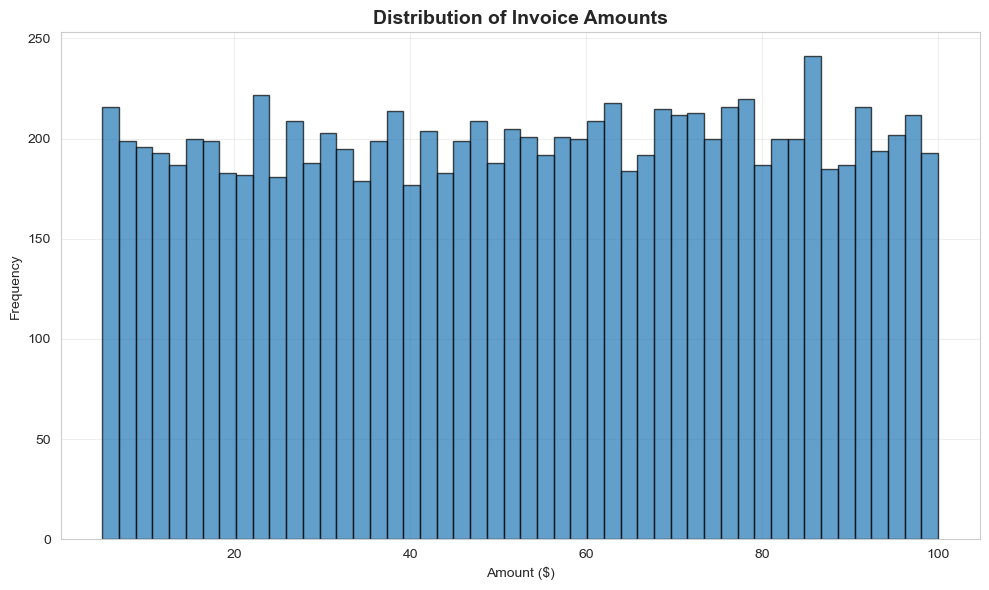

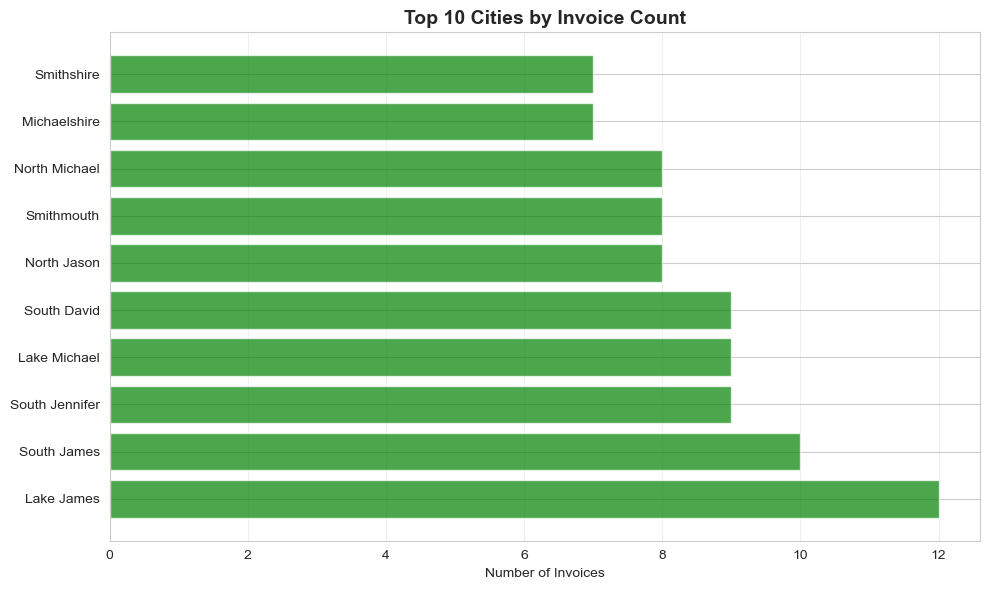

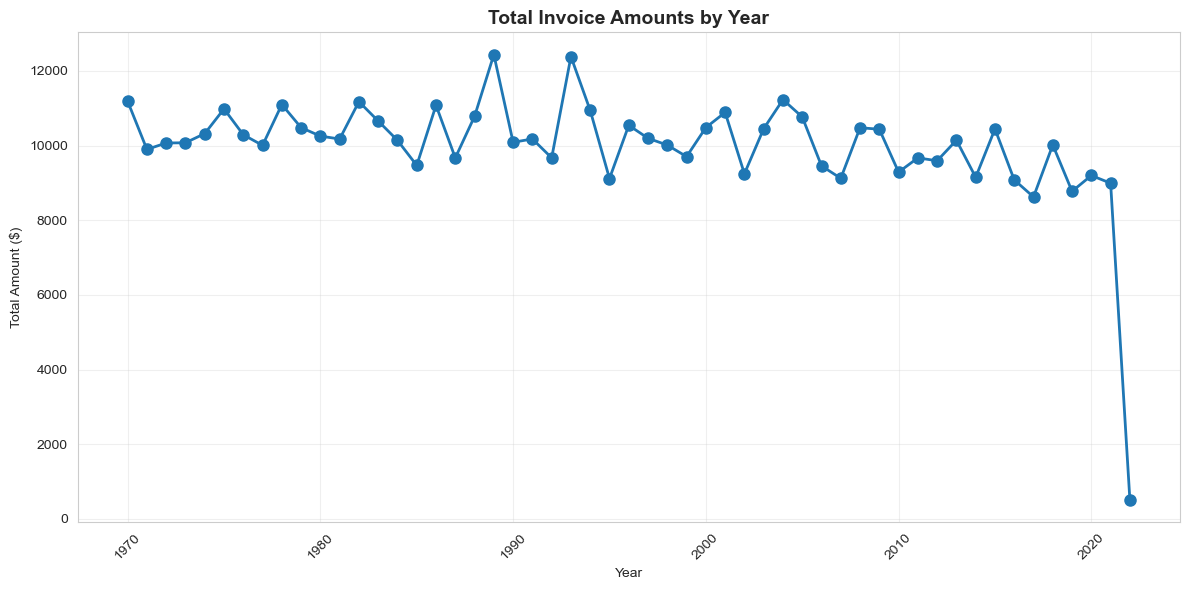


[Step 2] INFORMATION EXTRACTION USING ADVANCED TECHNIQUES

[Step 2.1] Applying Grouping Queries...

GROUPING QUERIES RESULTS

Job Category with Most Invoices:
  Job Category: ('Research scientist (life sciences)', 29)

Product with the Highest Quantity Sold:
  Product ID: (164, 775)

City with the Highest Average Invoice Amount:
  City: ('East Summerview', 99.99)

City with the Most Unique Customers:
  City: ('Lake James', 12)

[Step 2.2] Applying Data Transformation Methods...

DATA TRANSFORMATION RESULTS


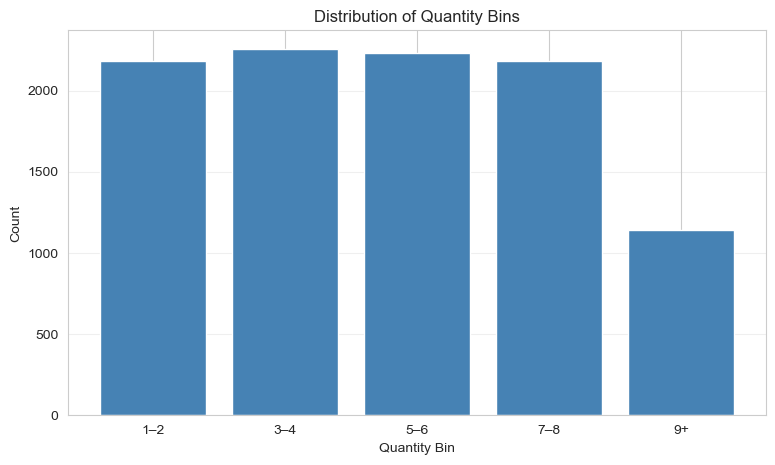

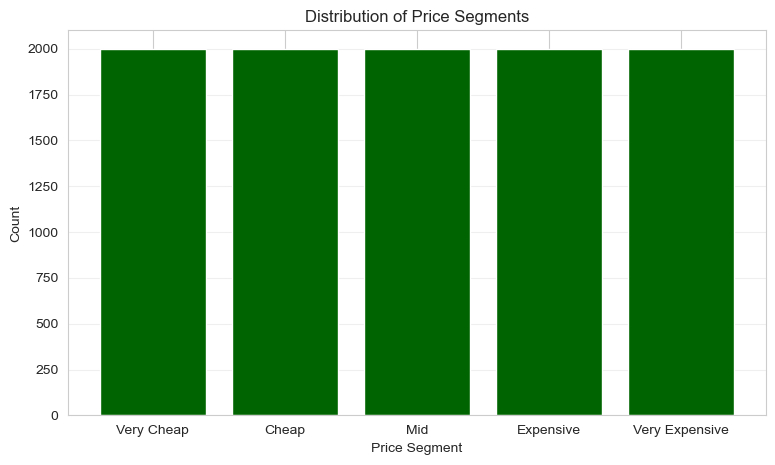

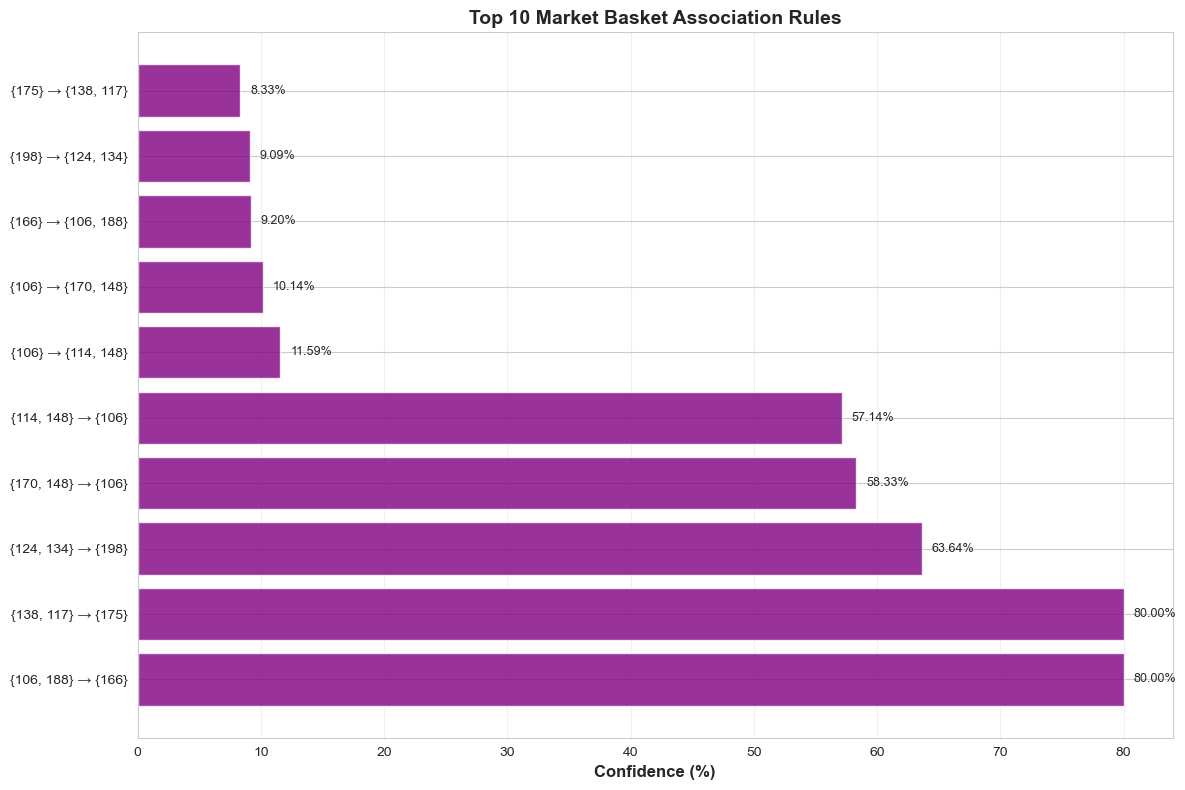


DATA TRANSFORMATION RESULTS SUMMARY

Discretization Statistics:
  Low ($5.01-$24.28): 2,001 invoices (20.0%)
  Medium-Low ($24.28-$43.67): 1,999 invoices (20.0%)
  Medium ($43.67-$62.73): 2,000 invoices (20.0%)
  Medium-High ($62.73-$81.28): 2,001 invoices (20.0%)
  High ($81.28-$99.99): 1,999 invoices (20.0%)

Frequent Patterns Found: 10
Top 3 Association Rules:
  166 → 106, 188: Support = 1.25%, Confidence = 9.20%, Lift = 5.88
  106, 188 → 166: Support = 1.25%, Confidence = 80.00%, Lift = 5.88
  170, 148 → 106: Support = 1.10%, Confidence = 58.33%, Lift = 5.40


[Step 2.3] Performing Temporal Analysis with Forecasting...


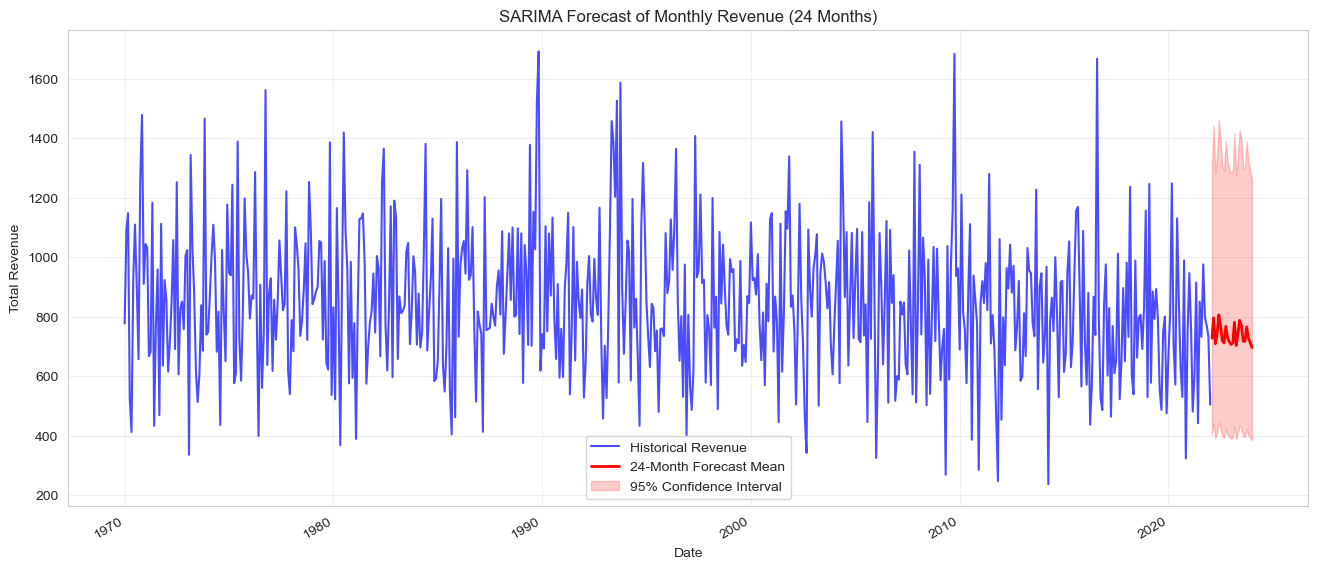

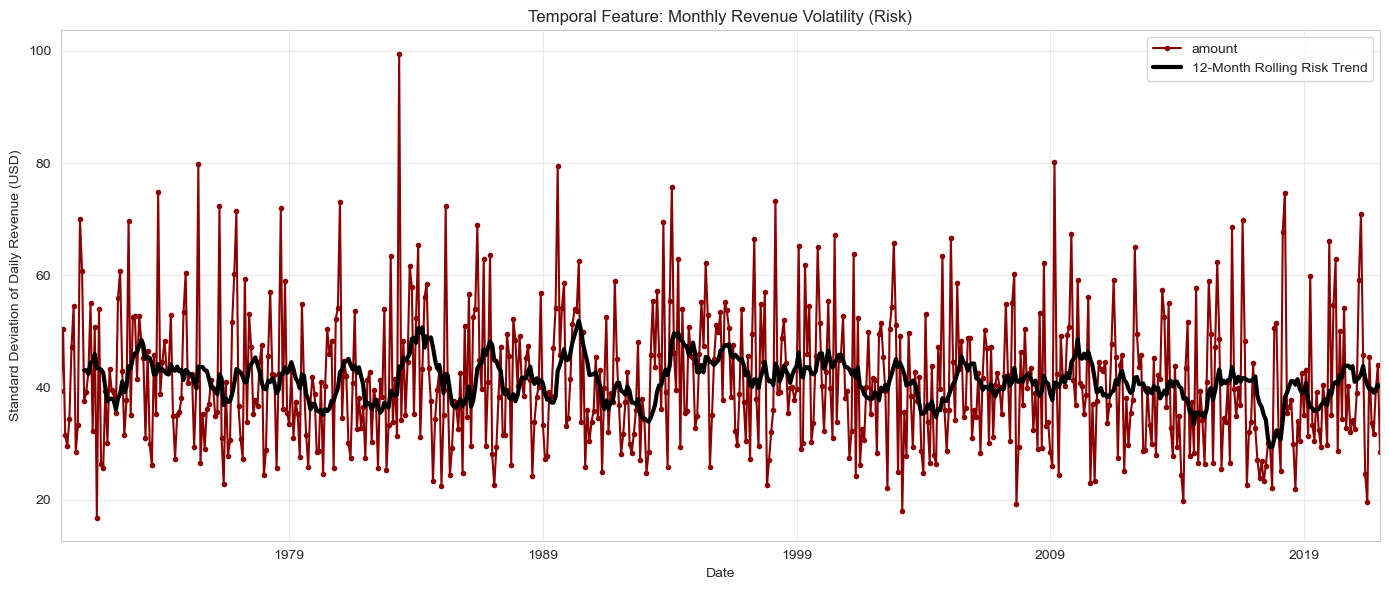


[Step 3] LAUNCHING INTERACTIVE DASHBOARD

Creating and launching Dash dashboard...
The dashboard will be available at http://127.0.0.1:8051


In [ ]:
# Execute the main function to run the complete analysis
df, exploration_results = main()